# A Tutorial Introduction to QAOA

This notebook presents an instructive implementation of **Quantum Approximate Optimization Algorithm (QAOA)**.

It walks you through the core concepts of the algorithm, and then an implementation for MAXCUT problem, a NP-Hard combinatorial optimization problem.

## Brief Description of QAOA algorithm

<img src="images/QAOA-Diagrams/VQA.PNG" width="750" height="300">

QAOA is an instance of variational quantum algorithms (VQA). The key idea behind QAOA, like any VQA, begins with a parameterized quantum circuit, often called an *ansatz*. This circuit includes adjustable rotation angles or other tunable values that influence how the quantum state evolves. With these parameters set to some initial values, the circuit is executed on a quantum computer, which returns a set of measurement outcomes, usually bitstrings like 0101 or 1110. These bitstrings represent candidate solutions to the problem at hand.

Next, these solutions are evaluated by a classical computer using a cost function. This cost function depends on the problem; for instance, for the optimization problem MAXCUT, it computes the number of edges crossing a cut (see the description of the MAXCUT problem below). Using the cost function an expectation value of the cost is calculated, and is used to determine the loss which is the target to minimize.

After scoring the results, a classical optimization algorithm updates the parameters of the quantum circuit. This could be a gradient-free optimizer like Nelder-Mead, COBYLA, or SPSA, all of which tolerate noisy measurements well. In this notebook we have used Nelder-Mead optimizer. The circuit is updated with these new parameter values, and the quantum computer is run again.

This loop continues until the algorithm converges or reaches a stopping criterion. Over time, the quantum circuit becomes increasingly biased toward producing high-quality solutions.

## MAXCUT problem

Let $G = (V,E)$ be an undirected graph, where $V$ is the set of vertices in the graph, and $E \subseteq \{(i,j) | i,j \in V, i \neq j\}$, is the set of edges therein.

A cut is a partition of the vertex set into two disjoint subsets $𝑆$ and $S'$, such that $S \cup S' = V$ and $S \cap S' = \varnothing$. The cost of a cut is the number of edges that span this partition - or are cut by this partition. The MAXCUT problem is to find a partition that maximizes the cost of the cut. 

Figure below shows an example MAXCUT for a graph drawn in two different ways.
<br>
<img src="images/QAOA-Diagrams/MAXCUT-example.PNG" width="500">

MAXCUT is NP-hard and serves as a canonical benchmark for combinatorial optimization algorithms, including QAOA.

**Cut representation as a bitstring** Cut can be represented as a bitstring, where a bit position represents a vertex, and it value of 0 or 1 represents the set that vertex belongs to. In the example shown above, the cut can be represented as 11010 or 00101; vertex 0 being the least-significant bit and vertex 4 the most-significant bit.


## QAOA for MAXCUT
As mentioned earlier, QAOA uses a parameterized circuit, or *ansatz* whose parameters are tuned to get to the best approximation. The parameterized cuitcuit for QAOA is as shown below

<img src="images/QAOA-Diagrams/QAOA-MAXCUT.PNG" width="750">

The cost operator, $U_C(\gamma)$, is derived from a *cost hamiltonian* $H_C$ constructed for the graph. This cost hamiltonian is constructed to represent the energy as the cut value of the graph. Not going into a derivation here, we just mention that $U_C(\gamma)$ is a unitary operator $=e^{-i\gamma H_C}$, which gets composed by adding the following in the circuit for each edge $(i,j)$ in the graph -

```text
        qubit i ------o--------------------o-------
                      |                    |
        qubit j -----[X]---[Rz(-gamma)]---[X]------
```

And, the mixer operator, $U_B(\beta)$, is derived from a *mixer hamiltonian* $H_B$ and is a unitary $e^{-i\beta H_B}$, and gets composed by adding the following to each qubit in the circuit -

```text
        qubit k ------[H]---[Rz(2*beta)]---[H]------
```

A circuit with $p$ layers basically computes the expression $e^{-i\beta_p H_B}e^{-i\gamma_p H_C}...e^{-i\beta_1 H_B}e^{-i\gamma_1 H_C}\ket{+}^{\otimes n}$.

Please see the accompanying blog series [QAOA Step by Step: Concepts, Circuits, and Code for Quantum Enthusiasts](https://medium.com/TBD) **TBD STILL** for details on these operators.

With this background, let's get started ...

# Let's get started with the implementation

## Install Qucircuit to Run This Notebook
Ensure you have qucircuit installed, the next cell has `pip install` for that.  
Also, take a look [here](https://github.com/atulvarshneya/quantum-computing/tree/master/examples/qckt) for several example algorithm implementations, as well as Getting Started tutorials on qckt.

In [1]:
%pip install qucircuit -qU
%pip show qucircuit

Note: you may need to restart the kernel to use updated packages.
Name: qucircuit
Version: 3.0
Summary: Quantum computer programming with circuits paradigm
Home-page: https://github.com/atulvarshneya/quantum-computing
Author: Atul Varshneya
Author-email: atul.varshneya@gmail.com
License: GPL
Location: /home/atul/anaconda3/envs/py311-qc/lib/python3.11/site-packages
Requires: matplotlib, numpy, qusimulator
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## 0. Imports

First we import the required modules -
* qckt package modules (from qucircuit package) - these are used to build the quantum circuit for the QAOA algorithm, run it, and collect the measured outputs.
* optimization function from scipy.optimize - this is used for the classical part of the QAOA algorithm.
* Rest of the imports - numpy and matplotlib are used for general computations and plots to visualize the working of the various steps of the algorithm.

In [2]:
import qckt
import qckt.backend as bknd
import qckt.noisemodel as ns
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

## 1. Functions to construct and run QC circuit for QAOA

These functions are used to build and run the quantum circuit component of the QAOA algorithm.

<img src="images/QAOA-Diagrams/QAOA-MAXCUT.PNG" width="750">

As shown in the diagram above, the quantum circuit consists of two main parts - **preparing the initial state**, and **`n_layers` of $U_C$ and $U_B$ operators**. The measurement is performed as a *readout* operation after the circuit is run multi-shot.

**Building the QAOA circuit**

* **preparing the initial state**  This creates a superposition of all $2^N$ states ($N$ being number of vertices) with equal aplitudes. This superposition is setup by applying hadamard gate to each qubit in the circuit. The function `qaoa_init()` builds this part of the citrcuit. The rest of the circuit is meant to increase the amplitudes of the states that represent the maxcut, and correspondingly reduce the amplitude of others that do not.
* **`n_layers` of $U_C$ and $U_B$ operators**  The rest of the circuit (the bulk of the circuit) consists of repeated layers comprised of operators $U_C$ and $U_B$. To get a more detailed explanation of these please see the accompanying blog series [QAOA Step by Step: Concepts, Circuits, and Code for Quantum Enthusiasts](https://medium.com/TBD) **TBD STILL**. The functions `qaoa_cost()` and `qaoa_mixer()` build these two opertors, and the function `qaoa_layer()` constructs one layer using these two functions. Finally, the entire circiut is put together by the function `full_qaoa_circuit()`.

**Running the QAOA circuit**
* The top level function in these, `run_qaoa_circuit()` calls the function to build the overall circuit, runs it multi-shot, and then collects and returns the measurement results from the multi-shot run.

In [3]:

# Initial state
def qaoa_init(ckt, n_qubits):
    ckt.H(list(range(n_qubits)))  # Initial Hadamard
    return ckt


# Cost operator U_C(gamma) - this cost operator is specific to the MAXCUT problem
def qaoa_cost(ckt, edges, gamma):
    # U_C(gamma)
    for e in edges:
        ckt.CX(e[0], e[1])
        ckt.Rz(-gamma, e[1])
        ckt.CX(e[0], e[1])
    return ckt


# Mixer Hamiltonian U_B(beta)
def qaoa_mixer(ckt, n_qubits, beta):
    # U_B(beta)
    ckt.H(list(range(n_qubits)))
    ckt.Rz(2*beta, list(range(n_qubits)))
    ckt.H(list(range(n_qubits)))
    return ckt


# One QAOA layer
def qaoa_layer(ckt, n_qubits, edges, gamma, beta):
    # U_C(gamma)
    ckt = qaoa_cost(ckt, edges, gamma)
    # U_B(beta)
    ckt = qaoa_mixer(ckt, n_qubits, beta)
    return ckt


# Build full QAOA circuit
def build_qaoa_circuit(n_qubits,  edges, n_layers, gammavals, betavals):
    ckt = qckt.QCkt(n_qubits,n_qubits)
    ckt = qaoa_init(ckt, n_qubits)
    ckt.Border()
    for i in range(n_layers):
        ckt = qaoa_layer(ckt, n_qubits, edges, gammavals[i], betavals[i])
        ckt.Border()
    # ckt.M(list(range(n_qubits-1,0-1,-1)), list(range(n_qubits-1,0-1,-1)))
    return ckt


# Run QAOA circuit for given gamma and beta values
def run_qaoa_circuit(n_qubits, edges, n_layers, n_shots, gammavals, betavals):
    ckt = build_qaoa_circuit(n_qubits=n_qubits, n_layers=n_layers, edges=edges, gammavals=gammavals, betavals=betavals)

    # Optionally try with a noisey quantum computer, e.g. add some noise simulation like below
    # noise_profile = ns.NoiseProfile(noise_chan_allgates=ns.bit_flip(0.0002))
    # ckt.set_noise_profile(noise_profile=noise_profile)

    job = qckt.Job(ckt, shots=n_shots, qtrace=True)
    bkeng = bknd.DMQeng()
    bkeng.runjob(job)
    creg_counts = job.get_counts()

    return creg_counts

## 2. Functions for loss and cut-value calculations

`qaoa_cost_function()` calculates the cost of a given cut represented in form of a bitstring. `qaoa_loss_function()` calculates the loss for a set of measurements resulting from the readout from a circuit run multi-shot. `loss` is the estimated expectation value of the ansatz.

In [4]:
# convert measurement result to bitstring
def __measured_result_to_bitstring(meas_result, n_qubits):
    bitstring = ''
    for i in range(n_qubits):
        bit = (meas_result >> i) & 1
        bitstring = str(bit) + bitstring
    return bitstring

# Cost function
def qaoa_cost_function(bitstring, edges):
    n_vertices = len(bitstring)
    cost = 0
    for e in edges:
        if bitstring[n_vertices-e[0]-1] != bitstring[n_vertices-e[1]-1]:
            cost += 1
    return cost

# Loss function
def qaoa_loss_function(counts, edges, n_vertices):
    total_cost = 0
    total_counts = 0
    for meas_result, count in counts.items():
        bitstring = __measured_result_to_bitstring(meas_result, n_vertices)
        cost = qaoa_cost_function(bitstring, edges)
        total_cost += cost * count
        total_counts += count
    avg_cost = total_cost / total_counts
    return -avg_cost  # We minimize negative of cost

## 3. Optimization (Nelder-Mead) method (scipy.optimize.minimize) - to find optimal $\gamma$ and $\beta$

### Objective function

The objective function takes the parameters `gamma` and `beta` as arguments, which are tuned by the optimizer, along with additional arguments `n_vertices`, `edges`, `n_layers`and `n_shots`. The objective function creates the circuit using these, runs the circuit multi-shot (`n_shots`), collects the measurements, and returns the corresponding `loss` value.

In [5]:
def objective_function(params, n_vertices, edges, n_layers, n_shots):
    # print(f'Inside objective fn -- N_vertices: {n_vertices}, Edges: {edges}, N_Layers: {n_layers}, N_shots: {n_shots}')
    gammavals = params[0:n_layers]
    betavals = params[n_layers:]
    counts = run_qaoa_circuit(n_qubits=n_vertices, edges=edges, n_layers=n_layers, n_shots=n_shots, gammavals=gammavals, betavals=betavals)
    loss = qaoa_loss_function(counts=counts, edges=edges, n_vertices=n_vertices)
    return loss

### The optimizer function
Uses Nelder-Mead method to minimize `loss` by tuning the parameters `params`. Uses the objective function to determine loss for a given value of params values.

Uses a callback function to capture the trace of params and loss evolution over the optimization steps.

In [6]:
def qaoa_optimize(edges, n_vertices, n_layers, n_shots, params, maxiter):

    trace = []
    # This function is used to generate a trace of optimizer loop, helps with some insights
    def callback_fn(intermediate_result):
        tr = trace
        split = int(len(intermediate_result.x) / 2)
        gammavals = intermediate_result.x[0:split]
        betavals = intermediate_result.x[split:]
        loss = intermediate_result.fun
        tr.append({"gammavals":gammavals, "betavals":betavals, "loss":loss})

    opt_res= minimize(
        fun=objective_function, 
        x0=params,
        args=(n_vertices, edges, n_layers, n_shots),
        method='Nelder-Mead', 
        options={'maxiter': maxiter},
        callback=callback_fn,
        )
    print(f"Optimization results: Loss  = {opt_res.fun},  Parameters = {opt_res.x}")
    # plot_gamma_beta_evolution(trace)

    return opt_res, trace

### A utility function to plot gamma and beta evolution at each optimization step
This function helps to visualize how the scipy.optimize.minimize incrementally tunes the gamma and beta values -- just to gain some insight into the working of optimizer.

In [7]:
def plot_gamma_beta_evolution(trace):
    # Plot gamma evolution over iterations, and another plot for gamma and beta evolotion over iteration
    plt.figure(figsize=(8, 5))
    for i in range(len(trace[0]['gammavals'])):
        plt.plot([item['gammavals'][i] for item in trace], marker='o', label=f"Gamma{i}")
    for i in range(len(trace[0]['betavals'])):
        plt.plot([item['betavals'][i] for item in trace], marker='o', label=f"Beta{i}")
    plt.xlabel('Iteration')
    plt.ylabel('Gamma and Beta')
    plt.title('Gamma and Beta Evolution Over Iterations')
    plt.legend()
    plt.grid()
    plt.show()

# Now let us take an example graph and find MAXCUT for it

## Specify a graph

<img src="images/QAOA-Diagrams/example-graphs.PNG" width="750">

In [8]:
# Example 1
# edges = [(0, 1), (2, 0)]
# n_vertices = 3

# Example 2
# edges = [(0, 1), (1, 2), (2,3), (3,0), (1,4), (4,2)]
# n_vertices = 5

# Example 3
edges = [(0,1), (0,2), (0,3), (0,4), (0,5), (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5), (3,4), (3,5), (4,5)]
n_vertices = 6

## Run through the algorithm

In [9]:
n_layers = 3
n_shots = 2000
maxiter = 50

gammavals = [0.5, 0.5, 0.5]
betavals = [0.5, 0.5, 0.5]
params = gammavals + betavals

opt_res, trace = qaoa_optimize(edges=edges, n_vertices=n_vertices, n_layers=n_layers, n_shots=n_shots, params=params, maxiter=maxiter)

Optimization results: Loss  = -8.6505,  Parameters = [0.37706332 0.63156509 0.35729525 0.43864106 0.67171362 0.41030753]


## Analyze the results
The optimal values of gamma and beta should yield a high probability of measuring the optimal solution from the quantum circuit.

For the results -

1. plot the counts for the various cost values
2. calculate percentage of counts for the max cost

In [10]:

def analyze_results(n_qubits, edges, n_layers, n_shots, gammavals, betavals):

    # using the tuned gamma and beta values, run the circuit to get the readout of the result
    best_counts = run_qaoa_circuit(n_qubits=n_qubits, edges=edges, n_layers=n_layers, n_shots=n_shots, gammavals=gammavals, betavals=betavals)
    # from the readout, find the measured value with maximum counts
    best_meas = max(best_counts, key=best_counts.get)
    print(f"Max frequency measured value: {__measured_result_to_bitstring(best_meas,n_vertices)}, Cost: {qaoa_cost_function(__measured_result_to_bitstring(best_meas,n_vertices), edges)}")


    # from the measurements, collect counts for each cost value
    from collections import defaultdict
    costs_vs_counts = defaultdict(int)
    for meas,count in best_counts.items():
        bitstring = __measured_result_to_bitstring(meas, n_vertices)
        cost = qaoa_cost_function(bitstring=bitstring, edges=edges)
        costs_vs_counts[cost] += count
    costsarr,countsarr = zip(*costs_vs_counts.items())


    # calculate the percentage of counts for max cost (max cut)
    maxcut = max(costsarr)
    freq_good = 0
    freq_bad = 0
    for i,count in enumerate(costsarr):
        if count == maxcut:
            freq_good += countsarr[i]
        else:
            freq_bad += countsarr[i]
    print(f"Percentage of good results: {100.0 * freq_good/(freq_good+freq_bad)}%")
    print(f"Frequency of good results: {freq_good}, Frequency of bad results: {freq_bad}")

    # plot counts for each cost value
    plt.bar(costsarr,countsarr)


Max frequency measured value: 100101, Cost: 9
Percentage of good results: 70.5%
Frequency of good results: 1410, Frequency of bad results: 590


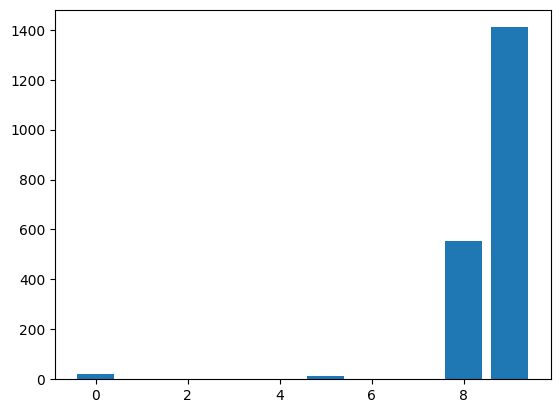

In [11]:
# Take the gamma and beta values from the optimization result
res_x = (opt_res.x).tolist()
gammavals = res_x[0:n_layers]  # the optimal values from previous step
betavals = res_x[n_layers:]  # the optimal values from previous step

analyze_results(n_qubits=n_vertices, edges=edges, n_layers=n_layers, n_shots=n_shots, gammavals=gammavals, betavals=betavals)

## Another optimization scheme - optimization in multiple steps

Theoretically, the larger the number of layers in the circuit, the more accurate are the quantum circuit outputs. However, while for a single layer, the loss function is quite smooth and sinusoidal-ish in shape, for larger number of layers it is very jagged hence poses some challenge for optimizing algorithms.

To illustrate this, below we plot beta vs loss for different number of layers.

### gamma, beta vs loss for different n_layers

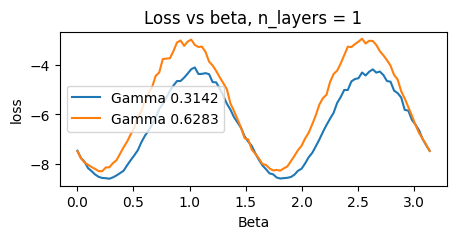

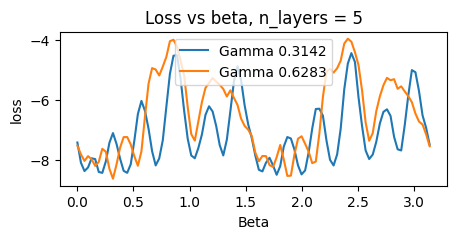

In [12]:
def plot_losss_vs_gamma(n_layers):
    plt.figure(figsize=(5, 2))
    for gamma in [pi/10, pi/5]:
        trace = []
        for beta in np.linspace(0,pi,100):
            gammavals = [gamma] * n_layers
            betavals = [beta] * n_layers
            # this is for illustration only, so to simpligy we use same gamma and beta for all layers
            counts = run_qaoa_circuit(n_qubits=n_vertices, edges=edges, n_layers=n_layers, n_shots=2000, gammavals=gammavals, betavals=betavals)
            loss = qaoa_loss_function(counts, edges, n_vertices)
            # print(gammavals, betavals, loss)
            trace.append({"gammavals":gammavals, "betavals":betavals, "loss":loss})
        plt.plot([row["betavals"][0] for row in trace], [row["loss"] for row in trace], label=f"Gamma {gamma:0.4f}")
        plt.title(f"Loss vs beta, n_layers = {n_layers}")
        plt.xlabel("Beta")
        plt.ylabel("loss")
        plt.legend()
    plt.show()

plot_losss_vs_gamma(n_layers=1)
plot_losss_vs_gamma(n_layers=5)

So, an approach that is sometimes followed is to start with a single layer circuit, and determine the optimal gamma and beta values for that. Next, use these gamma and beta values as starting ones for a circuit with 2 layers and find the optimal gamma and beta values for that sized circuit. Finally, these are used as the starting values for a circuit with 3 or 4 layers. Typically, this is sufficient, and no larger circuits are used.

Potentially, this scheme can help pick better gamma and beta values. We demonstrate that scheme below.

### Step 1

`n_layers` = 1

`gamma` and `beta` given some initial values as starting values.

In [13]:
n_layers1 = 1
n_shots1 = 2000
maxiter1 = 50

gammavals_init = [0.5]
betavals_init = [0.5]
params1 = gammavals_init + betavals_init

opt_res1, trace = qaoa_optimize(edges=edges, n_vertices=n_vertices, n_layers=n_layers1, n_shots=n_shots1, params=params1, maxiter=maxiter1)

Optimization results: Loss  = -8.43,  Parameters = [0.57773691 0.24921961]


### Step 2

`n_layers` = 2

`gamma` and `beta` starting values as the optimized values from previous step

In [14]:
n_layers2 = 2
n_shots2 = 2000
maxiter2 = 50

split = int(len(opt_res1.x) / 2)
res_x = (opt_res1.x).tolist()
gammavals = res_x[0:split] + [res_x[0]]*(n_layers2 - n_layers1)  # the optimal values from previous step, extended by a value for the additional layer
betavals = res_x[split:] + [res_x[split]]*(n_layers2 - n_layers1)  # the optimal values from previous step, extended by a value for the additional layer
params2 = gammavals + betavals

opt_res2, trace = qaoa_optimize(edges=edges, n_vertices=n_vertices, n_layers=n_layers2, n_shots=n_shots2, params=params2, maxiter=maxiter2)

Optimization results: Loss  = -8.916,  Parameters = [0.34397388 1.009065   0.25234826 0.12026654]


### Step 3

`n_layers` = 3

`gamma` and `beta` starting values as the optimized values from previous step

In [15]:
n_layers3 = 3
n_shots3 = 2000
maxiter3 = 50

split = int(len(opt_res2.x) / 2)
res_x = (opt_res2.x).tolist()
gammavals = res_x[0:split] + [res_x[0]]*(n_layers3 - n_layers2)  # the optimal values from previous step, extended by a value for the additional layer
betavals = res_x[split:] + [res_x[split]]*(n_layers3 - n_layers2)  # the optimal values from previous step, extended by a value for the additional layer
params3 = gammavals + betavals

opt_res3, trace = qaoa_optimize(edges=edges, n_vertices=n_vertices, n_layers=n_layers3, n_shots=n_shots3, params=params3, maxiter=maxiter3)

Optimization results: Loss  = -8.9725,  Parameters = [0.33715498 1.14975831 0.50941926 0.28307737 0.103585   0.04491659]


## Analyze the result

Max frequency measured value: 101100, Cost: 9
Percentage of good results: 97.45%
Frequency of good results: 1949, Frequency of bad results: 51


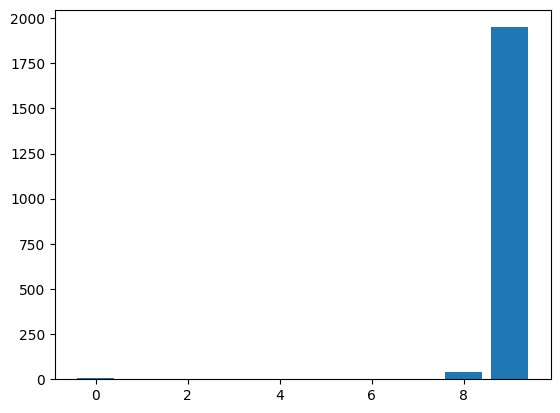

In [16]:
# Take the gamma and beta values from the optimization result
res_x = (opt_res3.x).tolist()
gammavals = res_x[0:n_layers3]  # the optimal values from previous step
betavals = res_x[n_layers3:]  # the optimal values from previous step

analyze_results(n_qubits=n_vertices, edges=edges, n_layers=n_layers, n_shots=n_shots, gammavals=gammavals, betavals=betavals)